
Proteus Tutorials![triton](http://proteustoolkit.org/_static/corps_logo_cross2.svg)
=================


June 16, 2017

Outline
========================

- Introduction to Proteus and basic tutorials
- Describing model domains and boundary conditions: `proteus.SpatialTools` and `proteus.BoundaryConditions`
- Simulating waves: `proteus.WaveTools`
- Random bits

What is  Proteus?
=================

A Python toolkit for solving equations

Find $u:\Omega \rightarrow \mathbb{R}$ satisfying
$$
\nabla \cdot (-a\nabla u) + r(x) = 0
$$
on 
$$
\Omega = [0,1] \times [0,1]
$$
subject to
$$
u|_{\partial \Omega} = 0
$$

Import some tools

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from proteus.iproteus import *
import proteus.default_p as physics 
import proteus.default_n as numerics
from proteus.TransportCoefficients import PoissonEquationCoefficients

Define the equation

In [2]:
def r(x):
    return (-32.*np.pi*2*
            np.sin(np.pi*2*x[...,0])*
            np.sin(np.pi*2*x[...,1])*
            np.cos(np.pi*2*x[...,0])*
            np.cos(np.pi*2*x[...,1]))
def a(x):
    return np.array([[1.0,0.0],
                     [0.0,1.0]])
physics.coefficients = PoissonEquationCoefficients([a],[r]) 
physics.name="PoissonDots"

Define the domain and boundary conditions

In [3]:
physics.nd = 2
physics.domain =  Domain.RectangularDomain(L=[1.0,1.0],
                                           x=[0.0,0.0])
def getDBC(x,flag):
    if flag in [physics.domain.boundaryTags['left'],
                physics.domain.boundaryTags['top'],
                physics.domain.boundaryTags['right'],
                physics.domain.boundaryTags['bottom']]:
        return lambda x,t: 0.0
        
physics.dirichletConditions = {0:getDBC}

Configure the numerics

In [4]:
numerics=default_n
numerics.femSpaces = {0:FemTools.P1}
numerics.elementQuadrature = Quadrature.SimplexGaussQuadrature(physics.nd,3)
numerics.elementBoundaryQuadrature = Quadrature.SimplexGaussQuadrature(physics.nd-1,3)
numerics.nn = 41
numerics.numericalFluxType = NumericalFlux.Diffusion_SIPG_exterior
so = default_so
so.name = physics.name
so.sList=[default_s]
so.tnList = [0,1]

Solve the problem

In [5]:
ns = NumericalSolution.NS_base(so,[physics],[numerics],so.sList,opts)
failed = ns.calculateSolution('run1')
assert(not failed)

Plot the solution

<IPython.core.display.Javascript object>


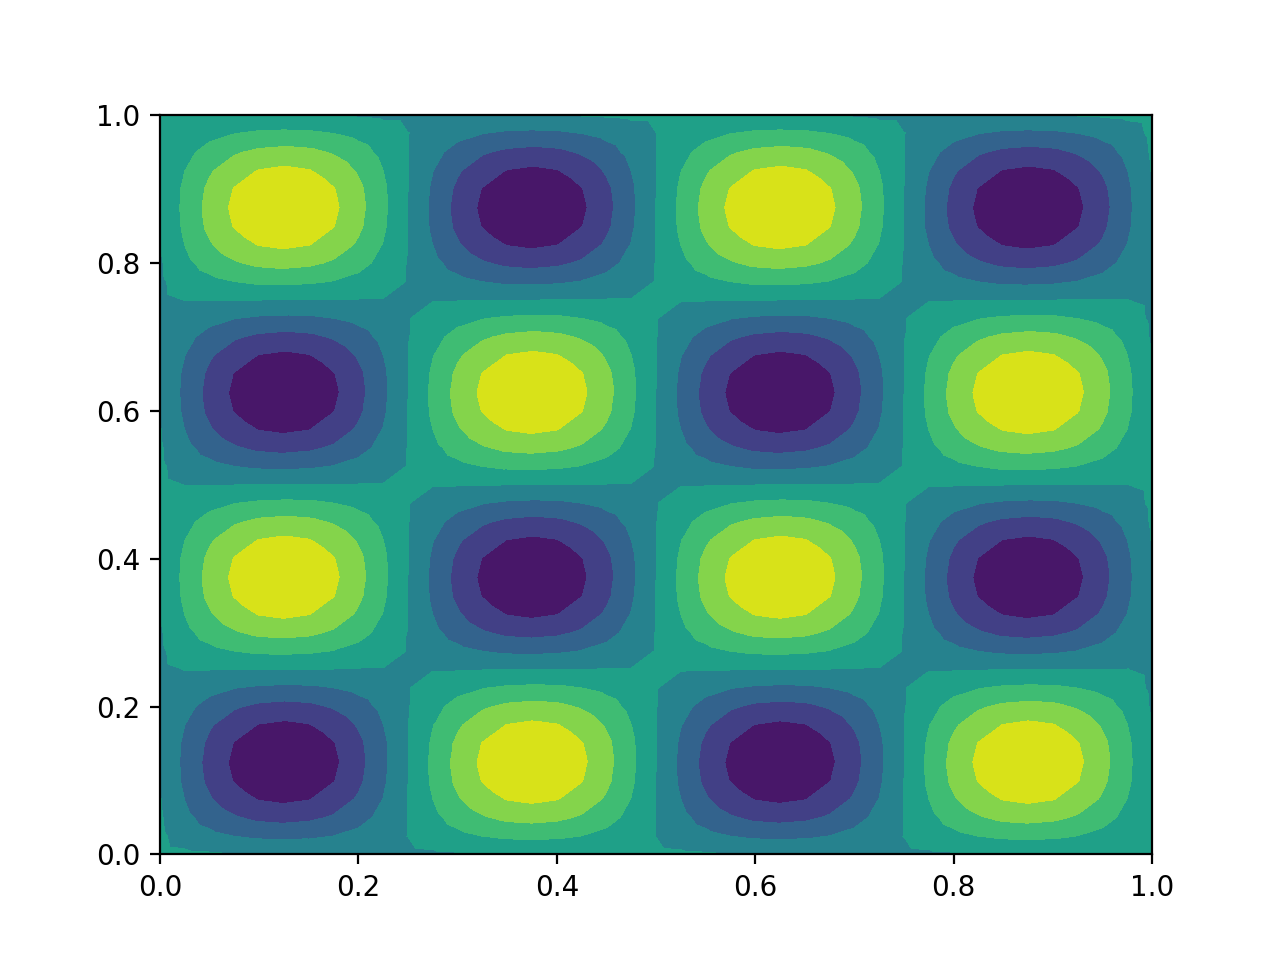

In [6]:
model = ns.modelList[0].levelModelList[-1]
plt.figure()
plt.tricontourf(model.mesh.nodeArray[:,0],
                model.mesh.nodeArray[:,1],
                model.mesh.elementNodesArray,
                model.u[0].dof)

What is  Proteus?
=================

A Python toolkit for research on ***continuum models***

In [7]:
class NonlinearPoisson(TransportCoefficients.TC_base):
    def __init__(self,A,rofx):
        TransportCoefficients.TC_base.__init__(self, 
                         nc=1, 
                         variableNames=['u'],
                         diffusion = {0:{0:{0:'constant'}}},
                         potential = {0:{0:'nonlinear'}},
                         reaction  = {0:{0:'constant'}})
        self.A=A;
        self.rofx=rofx
    def evaluate(self,t,c):
        c[('a',0,0)][...,0] = self.A[0][0]
        c[('a',0,0)][...,3] = self.A[1][1]
        c[('r',0)][:]       = self.rofx(c['x'][:])
        c[('phi',0)][:]     = c[('u',0)]**2+10.0*c[('u',0)]
        c[('dphi',0,0)][:]  = 2.0*c[('u',0)] + 10.0 

In [8]:
physics.coefficients = NonlinearPoisson([[1.0,0.0],[0.0,1.0]], r)
numerics.tolFac=0.0
numerics.nl_atol_res = 1.0e-8
numerics.nn=21

In [9]:
ns = NumericalSolution.NS_base(so,[physics],[numerics],so.sList,opts)
failed = ns.calculateSolution('run2')
assert(not failed)

<IPython.core.display.Javascript object>


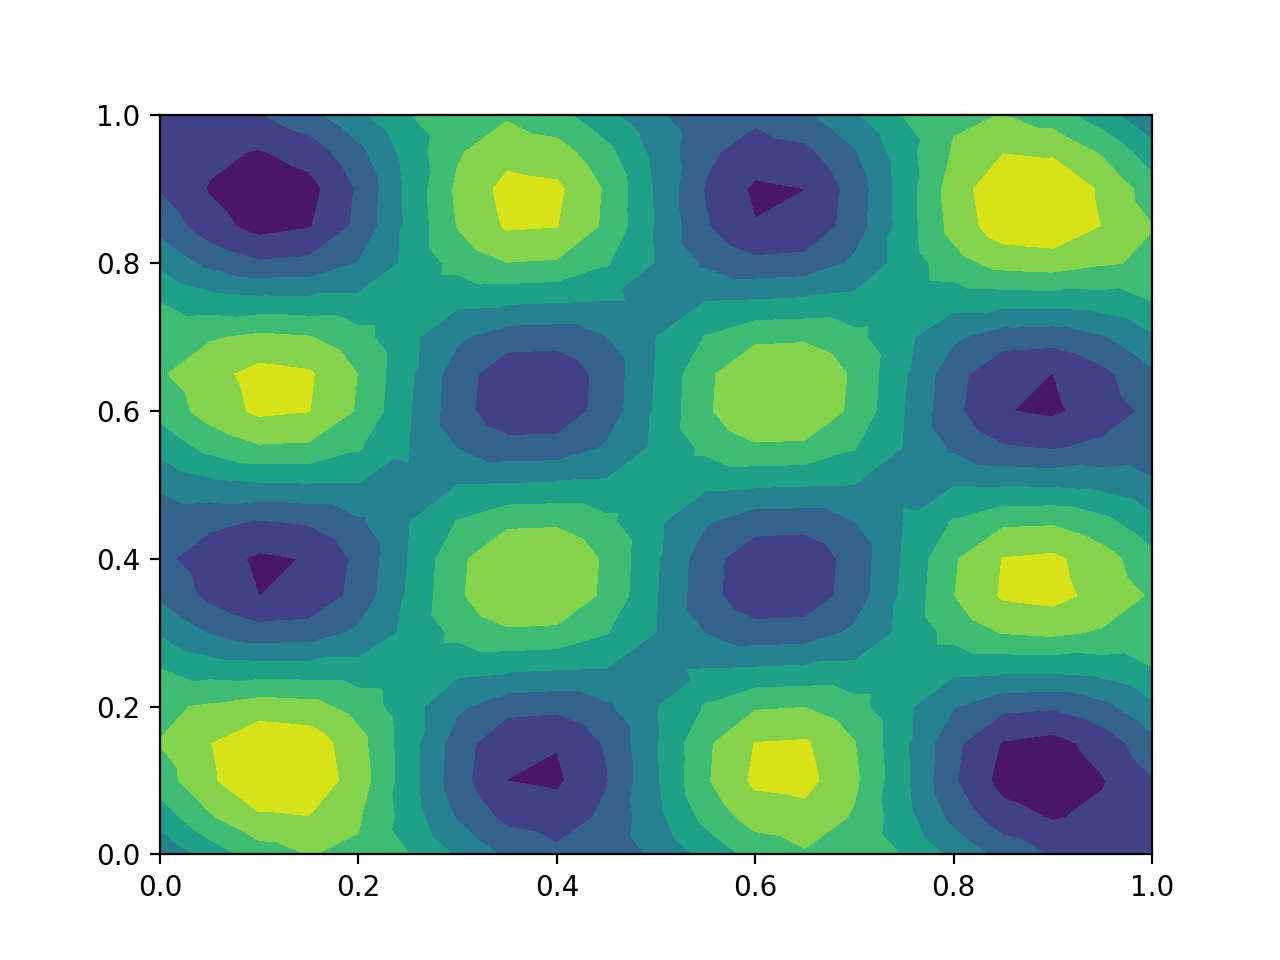

In [10]:
model = ns.modelList[0].levelModelList[-1]
plt.figure()
plt.tricontourf(model.mesh.nodeArray[:,0],
                model.mesh.nodeArray[:,1],
                model.mesh.elementNodesArray,
                model.u[0].dof)

What is  Proteus?
=================

A Python toolkit for research on ***numerical methods***

In [11]:
physics.coefficients = PoissonEquationCoefficients([a],[r]) 
numerics.femSpaces={0:FemTools.P2}
ns = NumericalSolution.NS_base(so,[physics],[numerics],so.sList,opts)
failed = ns.calculateSolution('run3')
assert(not failed)

<IPython.core.display.Javascript object>


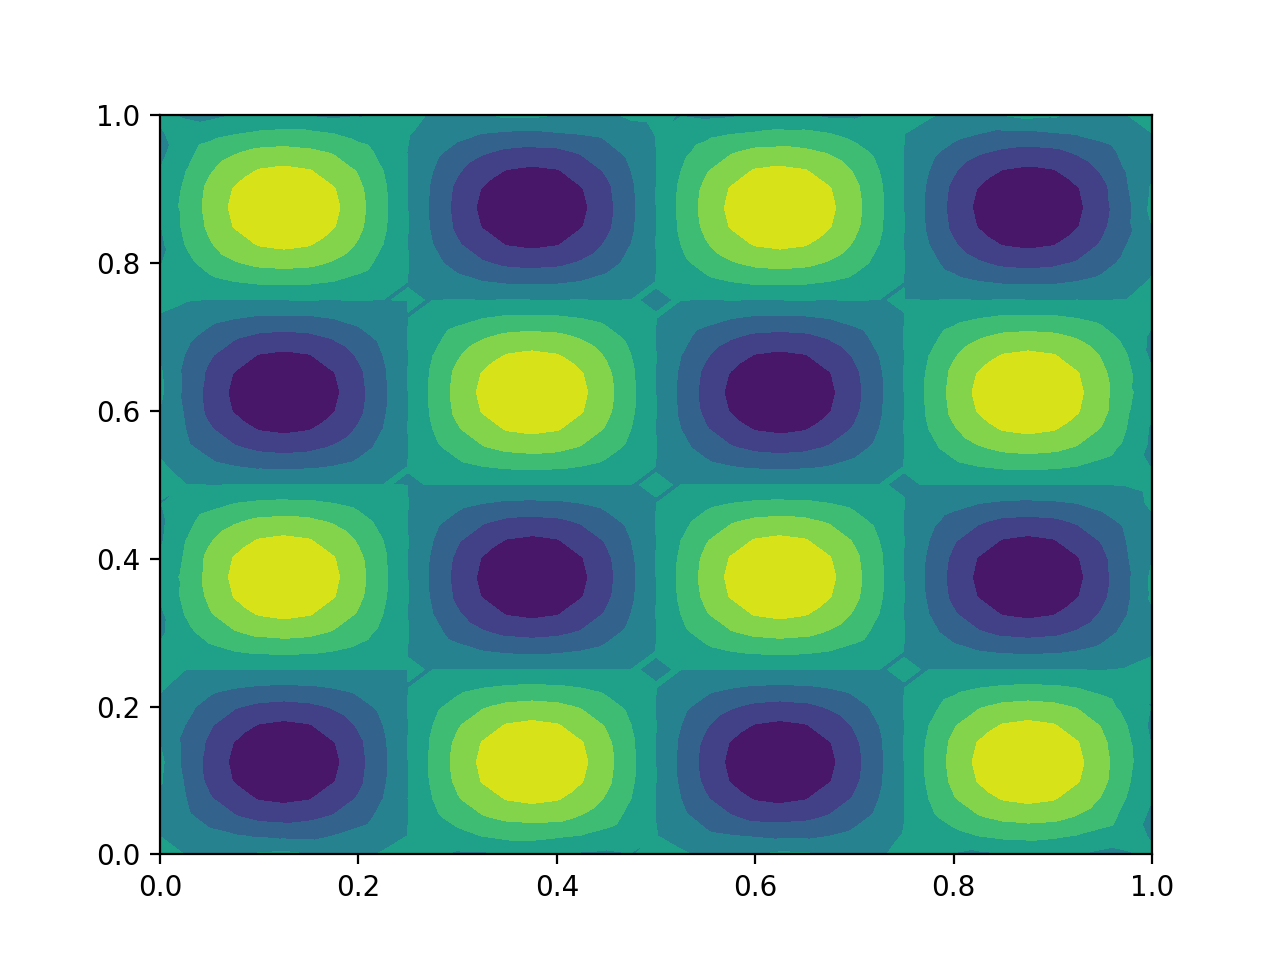

In [12]:
model = ns.modelList[0].levelModelList[-1]
import matplotlib.tri as tri
triang = tri.Triangulation(model.u[0].femSpace.dofMap.lagrangeNodesArray[:,0],
                model.u[0].femSpace.dofMap.lagrangeNodesArray[:,1])

plt.figure()
plt.tricontourf(triang, model.u[0].dof)

Proteus is a **not** one single model or method. 
===========================
- It's a toolkit (platform, middleware,...)
- It contains models and supports building modeling applications
- It contains numerical methods and supports developing new ones

What does this have to do with FSI?
===================================

- Many open questions or choices still exist about models and methods
- Many more open questions existed ten years ago
- There is no universal FSI formulation
- There is no best method for all flow regimes and applications

***To succeed in modeling FSI we need a platform for conducting research and streamlining the path from research to production models.*** 

![cartoon](images/fsi_simple.png)

Brief description of formulations and methods
=============================================
- Hybrid level set/volume-of-fluid methods for topological change
- Signed distance solvers (Eikonal equation)
- Transport solvers (VOF, Level Set)
- Navier-Stokes solvers (DNS, LES, RANS)
- Moving mesh methods for some solid/fluid interfaces
- Immersed/embedded methods for other solid/fluid interfaces

<video controls src="images/ubbink_vel.mp4" />

<video controls src="images/wigleyFineSurfZ.mp4" />

<video controls src="images/dtmb.mp4" />

<video controls alt="test" src="images/vofOpSlow4.mp4"/>


Air-Water Verification and Validation
=====================================
- Cooperative project with HR  Wallingford
- https://github.com/erdc-cm/air-water-vv